In [1]:
from numba import cuda, njit, vectorize, guvectorize, prange, float64
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.signal as signal

# load some data

In [2]:
data = loadmat('./data/sim_single_cyst.mat')
print(data.keys())

fs = np.squeeze(data['fs']) # sampling frequency
fs = np.float64(fs)
c = np.squeeze(data['c']) # speed of sound
# when c is uint16 it raise error, thus it should be casted into proper type
c = np.float64(c)

pitch = np.squeeze(data['pitch']) # pitch
angles = np.squeeze(data['angles']) # transmit angles

rf = np.squeeze(data['rf']) # radio-frequency (rf) data acquired by probe elements
rf = np.transpose(rf,(2,1,0))
# decimation - the fs=1e8 is not necessary high
dec = 4
rf = signal.decimate(rf, dec)
fs = fs/dec

print(f'sampling frequency [MHz]: {fs*1e-6}')


dict_keys(['__header__', '__version__', '__globals__', 'angles', 'c', 'fc', 'fs', 'pitch', 'rf', 'rfrc'])
sampling frequency [MHz]: 25.0


***
# FIR filter
***
<font size="4">
The finite impulse response (FIR) filter is given by equation \eqref{fir}

\begin{equation}
    y[n] = \sum_{k=0}^{N-1} h[k]x[n-k] 
    \label{fir} \tag{1}
\end{equation}

where *x* is an input signal, *h* is a filter impulse response and *y* is an output signal.
Filtration is realised by convolving the signal with impulse response of the filter.

  
    
***    
</font>

# FIR filter implementation - 1D (direct approach)

### define some functions

In [20]:
def present_signal(sig, fs, color='b', title=''):
    '''
    The function display input signal and its spectrum.
    '''
    f, p = signal.periodogram(sig,fs=fs)
    
    fig,ax = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(title)
    ax[0].plot(sig,color=color)
    ax[0].set_title('signal')
    ax[0].set_xlabel('samples')
    ax[0].set_ylabel('amplitude [a.u.]')
    
    ax[1].semilogy(f*1e-6, p/np.max(p),color=color)
    ax[1].set_title('power spectrum')
    ax[1].set_xlabel('frequency [MHz]')
    ax[1].set_ylabel('amplitude [a.u.]')
    
    plt.tight_layout()
    
    
def convolve(sig, h):
    '''
    The function convolve signals (sig) with filter impulse response (h).
    It convolve along the last dimension of sig array. 
    '''
    
    s = sig.shape
    sfshape = s[0:-1] + (s[-1] - h.shape[-1],)
    sigflt = np.zeros(sfshape)
    
    for i in range(sigflt.shape[-1]):
        sigflt[..., i] = np.sum(sig[...,i:i + h.size]*h[::-1])
        
    return sigflt

# convolve njit version
convolve_jit = njit()(convolve)


# experiment
# @guvectorize([(float64[:], float64[:], float64[:])], '(),()->()')
# def convolve_guv(sig, h, sigflt):
#     '''
#     The function convolve two signals.
#     '''
# #     sigflt = np.zeros(sig.size - h.size)
#     for i in range(sigflt.size):
#         sigflt[i] = np.sum(sig[i:i+h.size]*h[::-1])

        
@cuda.jit(device=True)
def dotproduct(a, b):
    '''
    Function enumerate dot product of two vectors.
    '''
    c = 0
    for i in range(a.size):
        c += a[i]*b[i]
    return c
    
# kernel    
@cuda.jit
def firkrn(rfflt, rf, w):
    """
    Kernel function.
    Realize FIR filtration by convolving signal sig with filter impulse response h.
    
    """
    
#     sh = cuda.shared.array(shape=w.shape, dtype=float64)
#     sh = h[::-1]
#     cuda.syncthreads()
    
    
    i, j, k = cuda.grid(3)
    if i >= rf.shape[0] or j >= rf.shape[1] or k >= rf.shape[2]-h.size:
        return
    
    # kernel does not return a value - it modifies one of arguments into result
    rfflt[i,j,k] = dotproduct(rf[i,j,k:k+w.size], w)

    

def fir(rf, h):
    '''
    Docstring
    '''
    
    
    n_transmissions, n_channels, n_samples = rf.shape    
    
    # allocate output array on the device
    n0, n1, n2 = rf.shape

    
    # put data arrays to the device
    rfflt = cuda.device_array((n0, n1, n2))
    
    rf = np.ascontiguousarray(rf)
    rf = cuda.to_device(rf)
    
    h = np.ascontiguousarray(h)
    h = cuda.to_device(h)

    
    
    # define thread per block and blocks per grid size
    # Note: total number of threads in block should not be bigger than 1024/512 (hardware dependent)
    blockshape = (8, 8, 8)
    gridshape_0 = (n0 + blockshape[0] - 1) // blockshape[0]
    gridshape_1 = (n1 + blockshape[1] - 1) // blockshape[1]
    gridshape_2 = (n2 + blockshape[2] - 1) // blockshape[2]
    gridshape = (gridshape_0, gridshape_1, gridshape_2)
    
    # run kernel
#     with cuda.defer_cleanup():
    firkrn[gridshape,blockshape](rfflt, rf, h[::-1])
    
    # transfer data from device to host
    rfflt = rfflt.copy_to_host()
    return rfflt    
    
    

CPU times: user 17.3 ms, sys: 433 µs, total: 17.8 ms
Wall time: 17.5 ms
(1789,)
(2045,)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function shared.array at 0x7f973e948940>) found for signature:
 
 >>> array(shape=UniTuple(int64 x 1), dtype=class(float64))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload of function 'array': File: numba/cuda/cudadecl.py: Line 44.
    With argument(s): '(shape=UniTuple(int64 x 1), dtype=class(float64))':
   No match.

During: resolving callee type: Function(<function shared.array at 0x7f973e948940>)
During: typing of call at <ipython-input-20-2c41cc6c3857> (71)


File "<ipython-input-20-2c41cc6c3857>", line 71:
def firkrn(rfflt, rf, w):
    <source elided>
    
    sh = cuda.shared.array(shape=w.shape, dtype=float64)
    ^


<ipython-input-20-2c41cc6c3857>:14: RuntimeWarning: invalid value encountered in true_divide
  ax[1].semilogy(f*1e-6, p/np.max(p),color=color)


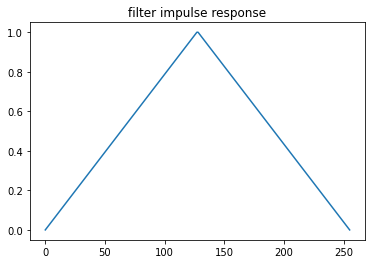

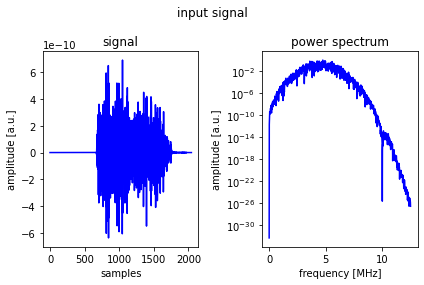

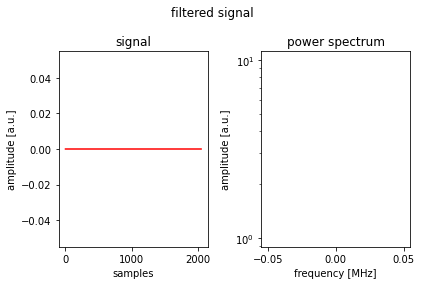

In [21]:
# get some signal from rf array
sig = rf[0,0,:]

# create filter impulse response (filter coefficient array)
ntaps = 256
h = np.concatenate((np.linspace(0, 1, ntaps//2),
                    np.linspace(1, 0, ntaps//2)))

# ordinary convolve
%time sigflt = convolve(sig, h)

print(sigflt.shape)
print(sig.shape)

# convolve compiled by jit (the time gain will be visible after second run)
# %time sigflt = convolve_jit(sig, h)

rfflt = np.zeros(rf.shape)
%time rfflt = fir(rf, h)



# fig,ax = plt.subplots(nrows=1, ncols=3)
# ax[0].plot(rf[0,0,:])
# ax[1].plot(rfflt[0,0,:])
# ax[2].plot(h)



# sigflt2 = np.zeros(sig.shape)
# print(sigflt2.shape)
# convolve_guv(sig, h, sigflt2)




sig = rf[0, 0, :]
sigflt = rfflt[0, 0, :]


# # do some graphs
fig,ax = plt.subplots(nrows=1, ncols=1)
ax.plot(h)
ax.set_title('filter impulse response')

present_signal(sig, fs, 'blue', 'input signal')
present_signal(sigflt, fs, 'red', 'filtered signal')


In [5]:
def dp(a, b):
    '''
    Function enumerate dot product of two vectors.
    '''
    c = 0
    for i in range(a.size):
        c += a[i]*b[i]
        
#     print(c)
    return c

rfflt = np.zeros(rf.shape)
for k in range(rf.shape[2]):
    rfflt[0, 0, k] = dp(rf[0,0,k:k+h.size], h)
    
print(8*8*16)

1024
